In [89]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime, time
from tqdm import tqdm
import os

In [90]:
def calculate_volatility(df, save_dir='temporal_data_10window'):
    os.makedirs(save_dir, exist_ok=True)
    
    df['datetime'] = pd.to_datetime(df['t'])
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.time
    
    market_open = time(9, 30)
    window_end = time(10, 0)
    
    window_data = df[
        (df['time'] >= market_open) & 
        (df['time'] < window_end)
    ]
    
    volatilities = {}
    for date, group in tqdm(window_data.groupby('date'), desc="Calculating volatilities"):
        vol = (group.sort_values(by="datetime")
               .reset_index(drop=True)
               .c.pct_change()  
               .rolling(10)    
               .std()         
               .dropna()      
               .values)     
        
        if len(vol) > 0: 
            tensor = torch.tensor(vol, dtype=torch.float32)
            volatilities[date] = tensor
            torch.save(tensor, os.path.join(save_dir, f'volatility_{date}.pt'))
    
    return volatilities

In [91]:
df = pd.read_csv("NDX_full_1min.csv", header=None, names=['t', 'o', 'h', 'l', 'c'])

In [92]:
df

,t,o,h,l,c
0,2008-01-02 09:30:00,2085.53,2087.02,2085.53,2087.02
1,2008-01-02 09:31:00,2088.11,2088.42,2087.95,2088.06
2,2008-01-02 09:32:00,2088.81,2089.92,2088.81,2089.92
3,2008-01-02 09:33:00,2089.53,2089.80,2089.45,2089.45
4,2008-01-02 09:34:00,2088.58,2090.53,2088.13,2090.53
...,...,...,...,...,...
1667413,2024-12-06 15:56:00,21620.82,21621.04,21615.06,21620.69
1667414,2024-12-06 15:57:00,21619.23,21621.82,21618.06,21620.49
1667415,2024-12-06 15:58:00,21621.33,21623.22,21615.26,21617.39
1667416,2024-12-06 15:59:00,21617.54,21623.23,21615.49,21618.06


In [93]:
volatility_tensors = calculate_volatility(df)

Calculating volatilities: 100%|██████████| 4263/4263 [00:04<00:00, 943.59it/s] 


In [94]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import matplotlib.pyplot as plt
import random
import glob

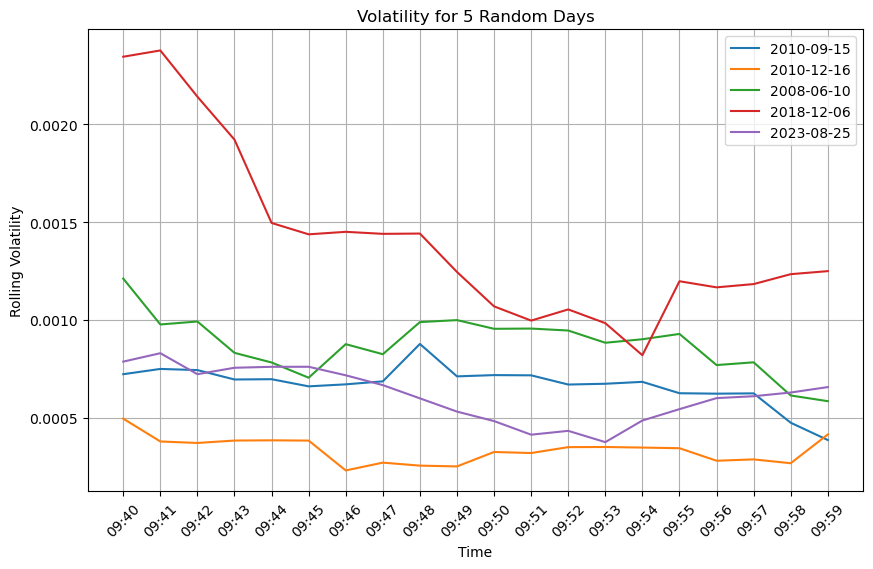

In [106]:
vol_files = glob.glob('temporal_data_10window/volatility_*.pt')

# randomly select 5 files
selected_files = random.sample(vol_files, 5)

plt.figure(figsize=(10,6))

for file in selected_files:
    date = file.split('volatility_')[1].split('.pt')[0]
    
    vol_tensor = torch.load(file)
    if vol_tensor.nelement() == 0:
        raise ValueError(f"Empty tensor loaded from {file}")
        
    vol_np = vol_tensor.numpy()

    # time axis
    times = [f"{9:02d}:{m:02d}" for m in range(40, 60)] # 9:35-9:54
    plt.plot(times, vol_np[:20], label=date)  # first 20 minutes of data

plt.title('Volatility for 5 Random Days')
plt.xlabel('Time')
plt.ylabel('Rolling Volatility')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()